# Run ACPIM and plot with CDP data

In [3]:
# Read in CDP data

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
import numpy as np
import glob
import netCDF4
from netCDF4 import Dataset
import subprocess

R = 287

# read in every .min file in subdirectories
CDP = pd.DataFrame()
for filename in glob.glob('./CDP/**/*.min'):
    df = pd.read_csv(filename, skiprows=2, sep=r"\s+",names=range(54)) # more than one delimiter (\s+)
                                                                       # label each column with numbers 0 - 54
    df.columns = df.iloc[0]                                            # get column names from first row
    df.drop(df.index[[0]], inplace=True)                               # delete first row
    df['datetime'] = df['Date'] + ' ' + df['Time']                     # create datetime column
    df['datetime'] = [dt.datetime.strptime(x, '%d/%m/%Y %H:%M:%S') for x in df['datetime']]
    df.index = df['datetime']                                          # use datetime as index
    CDP = CDP.append(df)                                               # append dataframes from each file together
        

# sort CDP by index so everything is in time order        
CDP = CDP.sort_index()
# replace NaNs with zeros
CDP.fillna(value=0, inplace=True)
# find indices to columns containing concentrations of each size bin
bin_first = CDP.columns.get_loc(3.0)
bin_last = CDP.columns.get_loc(50.0)
# Create array of binned data, CDP1
CDP1 = CDP.iloc[:,bin_first:bin_last+1]
# Create variable for sum of sizes above 12microns, ie ice
bin_12 = CDP.columns.get_loc(12.0)
bin_5 = CDP.columns.get_loc(5.0)
CDP12 = CDP.iloc[:,bin_12:bin_last+1].sum(axis=1)
CDP5 = CDP.iloc[:,bin_5:bin_last+1].sum(axis=1)

# Create array of size bins, sizes
sizes = np.array(CDP.columns)
sizes = sizes[bin_first:bin_last+1]


## Edit NAMELISTs for ACPIM and run simulation

Currently set up to change values of ALPHA and Aw used in criteria for ice formation.

To change different variables replace variable value in NAMELIST with -1111 or -2222 and change the value accordingly in the cell below (ALPHA/Aw corresponds to -1111/-2222).  

In [ ]:
# run acpim ./acpim_v17_test 
R = 287

ALPHA = 40
Aw = 0.99991

# run all namelists
for filename in glob.glob('../acpim_v17_test/Paper_redo_201117/*.IN'):
    
    edit_namelist = "sed -e 's/-1111/"+str(ALPHA)+"/' "+filename+" > temp.IN"
    subprocess.call([edit_namelist], shell=True)
    
    edit_namelist2 = "sed -e 's/-2222/"+str(Aw)+"/' temp.IN > temp2.IN"
    subprocess.call([edit_namelist2],shell=True)
    
    run_acpim = "./main.exe temp2.IN GRIDS.IN"
    subprocess.call([run_acpim], shell=True)

## Run ACPIM without editing NAMELISTS

Change path in 'glob.glob' to directory where NAMELISTS are.

This code will run all NAMELISTS in that path. 

In [ ]:
# run all namelists ./acpim_v17 
for filename in glob.glob('../acpim_v17/Paper_redo_201117/*.IN'):
    
    run_acpim = "../acpim_v17/main.exe "+filename+" GRIDS.IN"
    subprocess.call([run_acpim], shell=True)
    

/home/mbexkes3/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


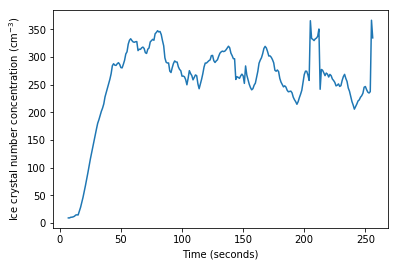

In [4]:
fig = plt.figure()

ax1 = fig.add_subplot(111) # 111 for one figure only, can be changed to eg. 321 which will give first
                           # plot in 2 columns of 3 rows of panels. 

    # start and end time of experiment for CDP
start = '2014-04-03 12:59:33'
end = '2014-04-03 13:04:00'

# read in and plot ACPIM output files
label_1 = '1' # line labels
label_2 = '2' #

nc = Dataset("../acpim_v17/output01_1259_Act_Nov17.nc", "r", format="NETCDF4")
ax1.plot(nc['TIMES'],((nc['NICE'][:,0,0,0]/1e6)*nc['PRESS'][:,0,0,0])/(R*nc['TEMP'][:,0,0,0]), label=label_1)
nc = Dataset("../acpim_v17/output01_1259_RH1_Nov17.nc", "r", format="NETCDF4")
ax1.plot(nc['TIMES'],((nc['NICE'][:,0,0,0]/1e6)*nc['PRESS'][:,0,0,0])/(R*nc['TEMP'][:,0,0,0]), label=label_2)

# plot CDP data for this eperiment
obs = []
obs = CDP12[start:end].rolling(8).mean().values
ax1.plot(obs)

ax1.set_ylabel('Ice crystal number concentration (cm$^{-3}$)')
ax1.set_xlabel('Time (seconds)')
plt.legend()

# add more panels to this plot by copying and pasting the above lines from 'ax1 = fig.add_subplot(111)'
# changing 111 to eg 321
# changing start and end time
# changing name of output files
# copy and paste as many times as panels you require



plt.show()